In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from gdeltdoc import GdeltDoc, Filters
from transformers import AutoTokenizer, AutoModelForSequenceClassification

sns.set_style('whitegrid')
%matplotlib inline

c:\Users\USER\anaconda3\envs\homework\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
tsla = yf.download("TSLA", start="2015-01-01", end="2025-11-13")
tsla.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_5372\3482032691.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tsla = yf.download("TSLA", start="2015-01-01", end="2025-11-13")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


In [23]:
#Add columns
def column_add(df)->pd.DataFrame:
    df['Returns'] = df['Close'].pct_change()
    df['LogReturns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA60'] = df['Close'].rolling(window=60).mean()
    df['Volatility20'] = df['Returns'].rolling(window=20).std()
    df['Volatility'] = df['Volatility20']* np.sqrt(252)  #Annualized Volatility
    return df

In [24]:
column_add(tsla)
tsla.head()

Price,Close,High,Low,Open,Volume,Returns,LogReturns,MA20,MA60,Volatility20,Volatility
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,,,,,,
Date,,,,,,,,,,,
2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500,-0.042041,-0.042950,NaN,NaN,NaN,NaN
2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500,0.005664,0.005648,NaN,NaN,NaN,NaN
2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000,-0.001562,-0.001563,NaN,NaN,NaN,NaN
2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500,-0.001564,-0.001566,NaN,NaN,NaN,NaN


In [25]:
tsla = tsla.dropna(how='all').asfreq('B').ffill()

In [26]:
import torch

NEWS_FILE = "financial_news.csv"
OUT_DAILY = "daily_news_finbert.csv"

df_news = pd.read_csv(NEWS_FILE)
df_news["dt"] = pd.to_datetime(df_news["dt"]).dt.date

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)
model.eval()

def finbert_score(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0
    inputs = tokenizer.encode_plus(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits
        probs = torch.softmax(logits, dim=-1)[0].tolist()
    pos, neu, neg = probs  # FinBERT order: [positive, neutral, negative]
    return float(pos - neg)


df_news["sentiment"] = df_news["body"].fillna("").apply(finbert_score)

print("Aggregating to daily level...")
daily = (
    df_news
    .groupby(["dt"], as_index=False)
    .agg(
        sentiment_mean=("sentiment", "mean"),
    )
)

daily.to_csv(OUT_DAILY, index=False)
daily.head()


Using device: cuda
Aggregating to daily level...


,dt,sentiment_mean
0,2015-01-02,-0.721631
1,2015-01-05,-0.724211
2,2015-01-07,-0.588047
3,2015-01-12,0.072181
4,2015-01-13,-0.820676


In [30]:
gd = GdeltDoc()

f = Filters(
    keyword="Tesla",
    start_date="2017-01-01",
    end_date="2025-11-13"
)

tesla_tone = gd.timeline_search("timelinetone", f)
tesla_tone['datetime'] = tesla_tone['datetime'].dt.date

def get_score(date):
    finbert_score = daily[daily.dt == date]
    if not finbert_score.empty:
        return finbert_score['sentiment_mean'].item()
    gdelt_score = tesla_tone[tesla_tone.datetime == date]
    if not gdelt_score.empty:
        return gdelt_score['Average Tone'].item()
    return 0.0

for dt in tsla.index:
    score = get_score(dt.date())
    tsla.loc[dt, 'sentiment'] = score    

In [31]:
tsla = tsla[['Close', 'LogReturns', 'sentiment']]

In [54]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, AdamW
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

scaler = StandardScaler()
tsla['LogReturns2'] = tsla['LogReturns']#y label로 쓰일 컬럼 복사
tsla.iloc[:,[1, 2]] = scaler.fit_transform(tsla.iloc[:,[1, 2]])


##merged_df preprocessing
'''
1. standard scaling 적용: 종목 [A], TSLA의 log return->모델의 input feature로 사용될 것이므로
2. tsla_log return(scaling 적용 x ground truth)->모델의 output으로 사용될 것이므로
3. tsla close price(최종적으로 예측하고자 하는 것)
'''

'\n1. standard scaling 적용: 종목 [A], TSLA의 log return->모델의 input feature로 사용될 것이므로\n2. tsla_log return(scaling 적용 x ground truth)->모델의 output으로 사용될 것이므로\n3. tsla close price(최종적으로 예측하고자 하는 것)\n'

In [12]:
def generate_dataset(df, input_idx, target_idx, window_size, test_n):
    x, y = [], []

    for i in range(len(df) - window_size):
        x.append(df.iloc[i:i+window_size, input_idx].values)
        y.append(df.iloc[i+window_size, target_idx])

    x = np.array(x)
    y = np.array(y)

    # -----------------------------
    # Time-based Train / Test split
    # -----------------------------
    test_idx = len(df) - test_n
    split_point = test_idx - window_size

    x_train = x[:split_point]
    y_train = y[:split_point]

    x_test = x[split_point:]
    y_test = y[split_point:]

    # -----------------------------
    # Train / Validation split
    # -----------------------------
    x_train, x_val, y_train, y_val = train_test_split(
        x_train, y_train,
        test_size=0.1,
        shuffle=False   # 시계열이므로 False
    )

    print(f"# Train: {y_train.shape[0]}")
    print(f"# Val:   {y_val.shape[0]}")
    print(f"# Test:  {y_test.shape[0]}")
    print(f"# Input shape: {x_train.shape[1:]}")

    return x_train, y_train, x_val, y_val, x_test, y_test


# 1. LSTM 모델

def build_lstm(input_shape):
    model = keras.Sequential([
        keras.layers.LSTM(
            64, activation='tanh',
            input_shape=input_shape,
            return_sequences=False
        ),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)
    ])
    model.compile(
        loss='mae',
        optimizer=Adam(0.001),
        metrics=['mae']
    )
    return model


In [16]:
def run_experiment(df, input_idx, target_idx, window_size):

    print("\n====================================")
    print(f" Running Window Size = {window_size}")
    print("====================================\n")

    # Dataset 생성
    test_n = int(0.2 * len(df))

    x_train, y_train, x_val, y_val, x_test, y_test = generate_dataset(
        df, input_idx, target_idx, window_size, test_n
    )

    # Model
    model = build_lstm((x_train.shape[1], x_train.shape[2]))

    checkpoint_path = f"./best_lstm_cols{input_idx}_ws{window_size}.weights.h5"

    cbk = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor="val_mae",
        mode="min",
        save_best_only=True
    )

    es = keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True
)


    # -----------------------------
    # Train
    # -----------------------------
    history = model.fit(
        x_train, y_train,
        epochs=200,
        batch_size=32,
        validation_data=(x_val, y_val),
        callbacks=[cbk, es],
        verbose=1
    )

    # -----------------------------
    # Test
    # -----------------------------
    model.load_weights(checkpoint_path)
    loss, mae = model.evaluate(x_test, y_test, verbose=0)
    print("\nTest MAE (log return):", mae)

    y_pred = model.predict(x_test).flatten()

    # Date index 추출
    test_idx = len(df) - test_n
    split_point = test_idx - window_size
    test_start_index = split_point + window_size

    date_index = df.index[
        test_start_index : test_start_index + len(y_test)
    ]
    # log return → TSLA Close Price 복원

    tsla_close_prev = df.iloc[
    test_start_index - 1 : test_start_index + len(y_test) - 1,
    0   # tsla_close column index
    ].values


    y_test_price = df.iloc[test_start_index:test_start_index+len(y_test),0].values #y_test: g.t tsla close price for test set->1이 tsla_close price column
    y_pred_price = tsla_close_prev * np.exp(y_pred) #이전 tsla close price * exp(predicted log return)->predicted close price

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(date_index, y_test_price, label="True TSLA Close", color="orange")
    plt.plot(date_index, y_pred_price, label="Predicted TSLA Close", color="skyblue")
    plt.title(f"TSLA Close Prediction (Window = {window_size})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Metrics
    mae_price = np.mean(np.abs(y_test_price - y_pred_price))
    rmse_price = np.sqrt(np.mean((y_test_price - y_pred_price)**2))
    direction_acc = np.mean(
    np.sign(np.diff(y_test_price)) == np.sign(np.diff(y_pred_price))
  )
    mape = np.mean(np.abs((y_test_price - y_pred_price) / y_test_price)) * 100


    result = {
        "MAE_price": mae_price,
        "RMSE_price": rmse_price,
        "MAPE_price": mape,
        "direction_acc": direction_acc
    }


    print("\nMetrics:")
    for k, v in result.items():
        print(f"{k}: {v:.4f}")

    return result


In [15]:
tsla

Price,Close,LogReturns,sentiment,LogReturns2
Ticker,TSLA,,,
Date,,,,
2015-01-02,14.620667,NaN,-0.348934,NaN
2015-01-05,14.006000,-1.222651,-0.348934,-0.042950
2015-01-06,14.085333,0.118630,-0.348934,0.005648
2015-01-07,14.063333,-0.080399,-0.348934,-0.001563
2015-01-08,14.041333,-0.080465,-0.348934,-0.001566
...,...,...,...,...
2025-11-06,445.910004,-1.019768,-0.989961,-0.035599
2025-11-07,429.519989,-1.070815,-1.248780,-0.037449



 Running Window Size = 100

# Train: 1951
# Val:   217
# Test:  566
# Input shape: (100, 2)
Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0388 - mae: 0.0388 - val_loss: 0.0290 - val_mae: 0.0290
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0290 - val_mae: 0.0290
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0291 - val_mae: 0.0291
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0291 - val_mae: 0.0291
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0290 - val_mae: 0.0290
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0291 - val_mae: 0.0291
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0290 - val_mae: 0.0290
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0248 - mae: 0.0248 

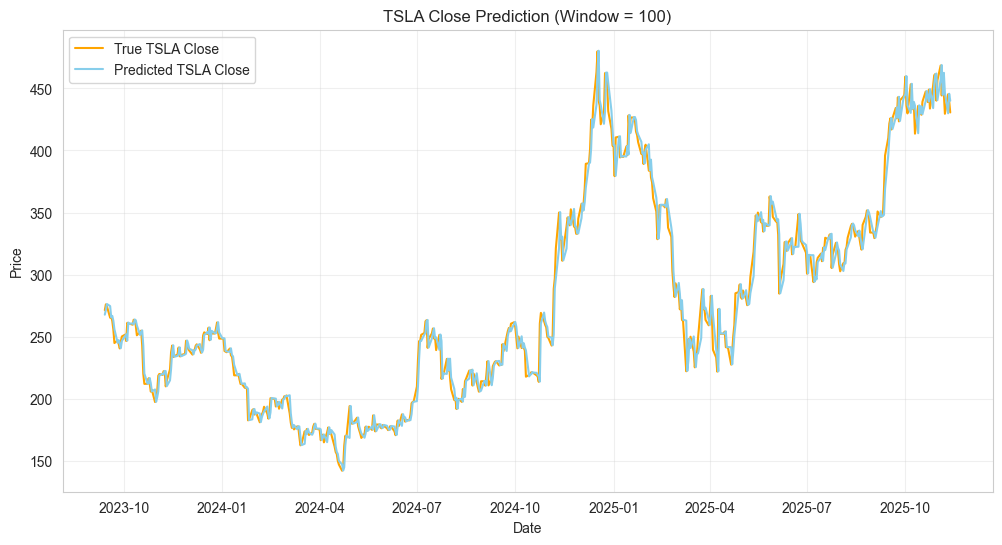


Metrics:
MAE_price: 7.5813
RMSE_price: 10.7588
MAPE_price: 2.7157
direction_acc: 0.4496


In [36]:
results = {}
ws = 100

results['base'] = run_experiment(tsla, [1, 2], 3, ws)


 Running Window Size = 100

# Train: 1951
# Val:   217
# Test:  566
# Input shape: (100, 2)
Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0293 - mae: 0.0293 - val_loss: 0.0290 - val_mae: 0.0290
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0290 - val_mae: 0.0290
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0291 - val_mae: 0.0291
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0290 - val_mae: 0.0290
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0291 - val_mae: 0.0291
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0247 - mae: 0.0247 - val_loss: 0.0290 - val_mae: 0.0290
Epoch 7/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0291 - val_mae: 0.0291
Epoch 8/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0248 - mae: 0.0248 

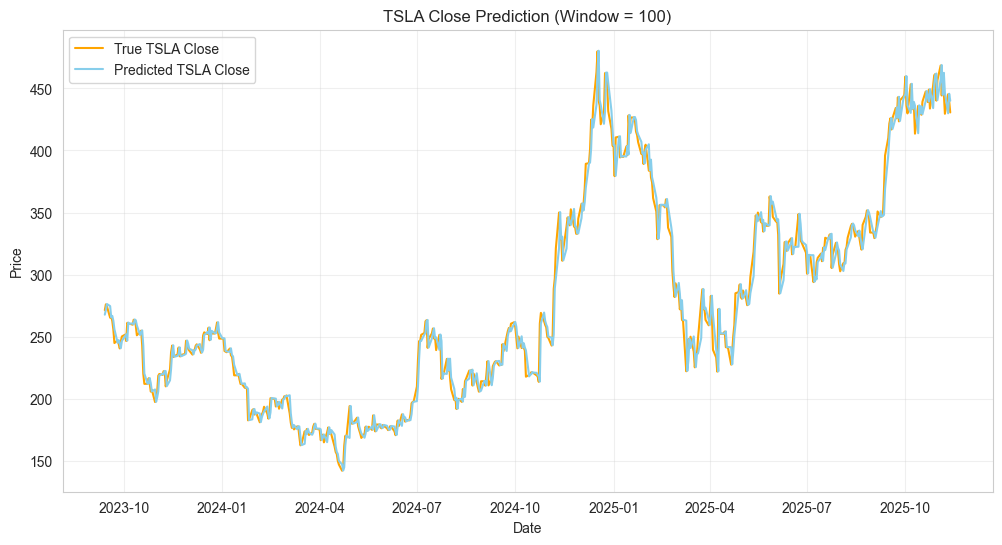


Metrics:
MAE_price: 7.5812
RMSE_price: 10.7588
MAPE_price: 2.7156
direction_acc: 0.4496


In [51]:
def build_lstm(input_shape):
    model = keras.Sequential([
        keras.layers.LSTM(
            64, activation='tanh',
            input_shape=input_shape,
            return_sequences=False
        ),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)
    ])
    model.compile(
        loss='mae',
        optimizer=Adam(1e-3),
        metrics=['mae']
    )
    return model


results = {}
ws = 100

results['variation1'] = run_experiment(tsla, [1, 2], 3, ws)


 Running Window Size = 20

# Train: 2023
# Val:   225
# Test:  566
# Input shape: (20, 2)
Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6709 - mae: 0.6709 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8161 - val_mae: 0.8161
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8161 - val_mae: 0.8161
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8161 - val_mae: 0.8161
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6700 - mae: 0.6700 - val_loss

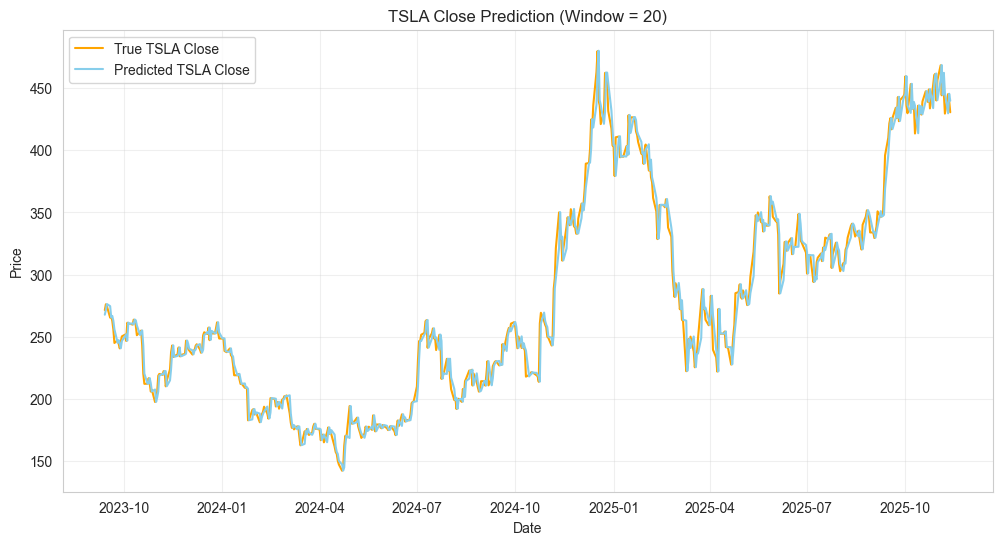


Metrics:
MAE_price: 7.5769
RMSE_price: 10.7582
MAPE_price: 2.7135
direction_acc: 0.4496


In [57]:
def build_lstm(input_shape):
    model = keras.Sequential([
        keras.layers.LSTM(
            64, activation='tanh',
            input_shape=input_shape,
            return_sequences=False
        ),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)
    ])
    model.compile(
        loss='mae',
        optimizer=AdamW(1e-3),
        metrics=['mae']
    )
    return model


results = {}
ws = 20

results['variation1'] = run_experiment(tsla, [1, 2], 3, ws)


 Running Window Size = 20

# Train: 2023
# Val:   225
# Test:  566
# Input shape: (20, 2)
Epoch 1/200


c:\Users\USER\anaconda3\envs\homework\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8159 - val_mae: 0.8159
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8161 - val_mae: 0.8161
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8159 - val_mae: 0.8159
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6701 - mae: 0.6701 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6700 - mae: 0.6

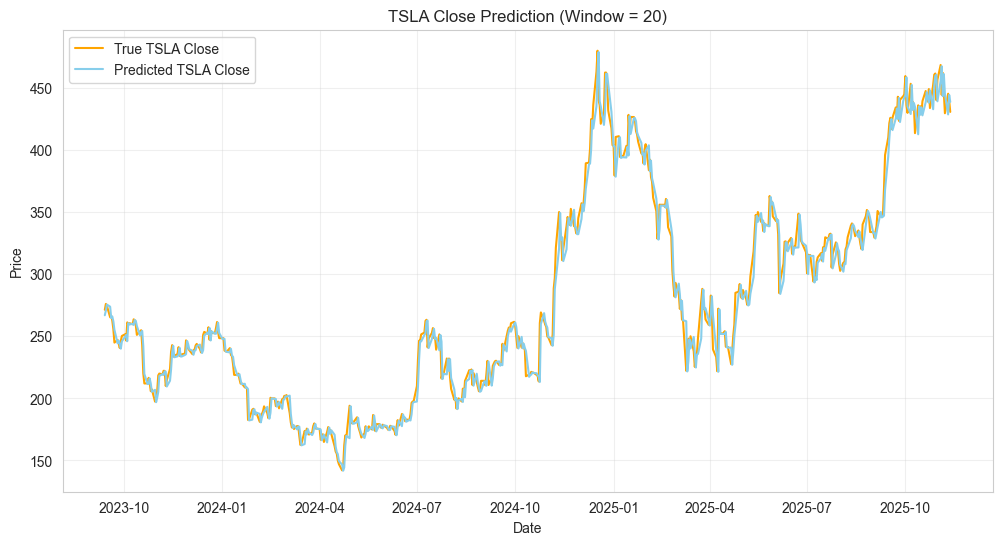


Metrics:
MAE_price: 7.6133
RMSE_price: 10.7860
MAPE_price: 2.7221
direction_acc: 0.4496


In [58]:
def build_lstm(input_shape):
    model = keras.Sequential([
        keras.layers.LSTM(
            64, activation='tanh',
            input_shape=input_shape,
            return_sequences=True
        ),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(
            64, activation='tanh',
            return_sequences=False
        ),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)
    ])
    model.compile(
        loss='mae',
        optimizer=AdamW(1e-3),
        metrics=['mae']
    )
    return model


results = {}
ws = 20

results['variation2'] = run_experiment(tsla, [1, 2], 3, ws)


 Running Window Size = 20

# Train: 2023
# Val:   225
# Test:  566
# Input shape: (20, 2)
Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6706 - mae: 0.6706 - val_loss: 0.8159 - val_mae: 0.8159
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8159 - val_mae: 0.8159
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8159 - val_mae: 0.8159
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8159 - val_mae: 0.8159
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6699 - mae: 0.6699 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6699 - mae: 0.6699 - val_los

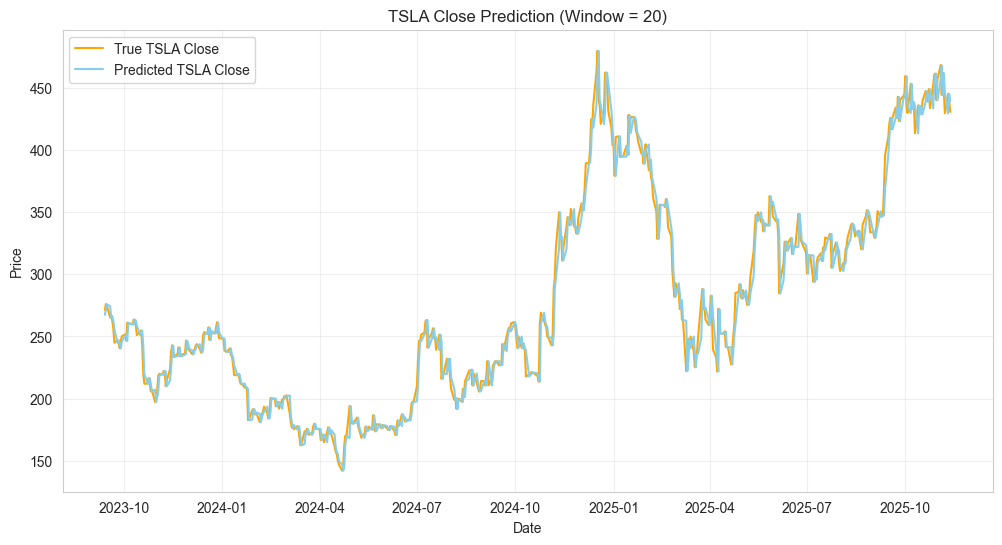


Metrics:
MAE_price: 7.5760
RMSE_price: 10.7615
MAPE_price: 2.7116
direction_acc: 0.4496


In [59]:
def build_lstm(input_shape):
    model = keras.Sequential([
        keras.layers.LSTM(
            64, activation='tanh',
            input_shape=input_shape,
            return_sequences=True
        ),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(
            64, activation='tanh',
            return_sequences=False
        ),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1)
    ])
    model.compile(
        loss='mae',
        optimizer=AdamW(1e-4),
        metrics=['mae']
    )
    return model


results = {}
ws = 20

results['variation2'] = run_experiment(tsla, [1, 2], 3, ws)


 Running Window Size = 20

# Train: 2023
# Val:   225
# Test:  566
# Input shape: (20, 2)
Epoch 1/200


c:\Users\USER\anaconda3\envs\homework\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6705 - mae: 0.6705 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6699 - mae: 0.6699 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6699 - mae: 0.6699 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6699 - mae: 0.6699 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6699 - mae: 0.6

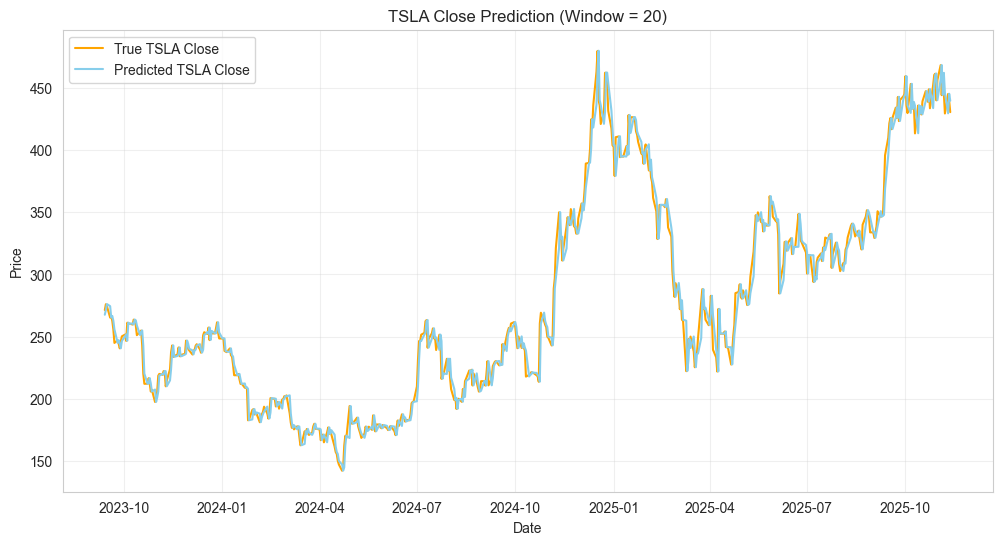


Metrics:
MAE_price: 7.5739
RMSE_price: 10.7583
MAPE_price: 2.7121
direction_acc: 0.4496


In [61]:
def build_lstm(input_shape):
    model = keras.Sequential([
        keras.layers.LSTM(
            64, activation='tanh',
            input_shape=input_shape,
            return_sequences=True
        ),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(
            64, activation='tanh',
            return_sequences=False
        ),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(1)
    ])
    model.compile(
        loss='mae',
        optimizer=AdamW(1e-4),
        metrics=['mae']
    )
    return model


results = {}
ws = 20

results['variation2'] = run_experiment(tsla, [1, 2], 3, ws)


 Running Window Size = 20

# Train: 2023
# Val:   225
# Test:  566
# Input shape: (20, 2)
Epoch 1/200


c:\Users\USER\anaconda3\envs\homework\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.6698 - mae: 0.6698 - val_loss: 0.8159 - val_mae: 0.8159
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6699 - mae: 0.6699 - val_loss: 0.8159 - val_mae: 0.8159
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6699 - mae: 0.6699 - val_loss: 0.8159 - val_mae: 0.8159
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6699 - mae: 0.6699 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6699 - mae: 0.6699 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6699 - mae: 0.6699 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6699 - mae: 0.6699 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6699 - mae: 0.6699 - val_loss: 0.8160 - val_mae: 0.8160
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6699 - mae: 0.6

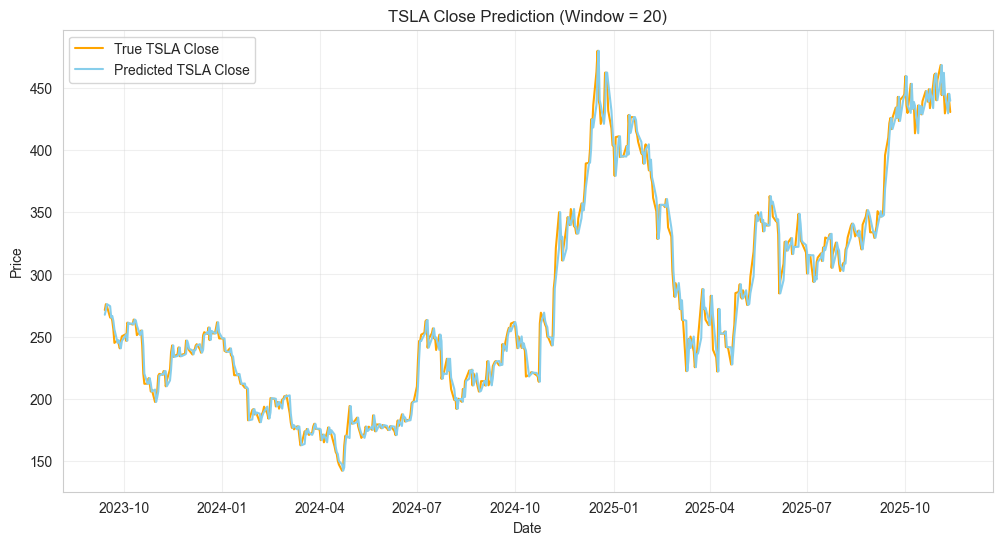


Metrics:
MAE_price: 7.5721
RMSE_price: 10.7586
MAPE_price: 2.7112
direction_acc: 0.4496


In [62]:
def build_lstm(input_shape):
    model = keras.Sequential([
        keras.layers.LSTM(
            64, activation='tanh',
            input_shape=input_shape,
            return_sequences=True
        ),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(
            64, activation='tanh',
            return_sequences=False
        ),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.15),
        keras.layers.Dense(1)
    ])
    model.compile(
        loss='mae',
        optimizer=AdamW(5e-5),
        metrics=['mae']
    )
    return model


results = {}
ws = 20

results['variation2'] = run_experiment(tsla, [1, 2], 3, ws)

#Final Performance
MAE_price: 7.5721
RMSE_price: 10.7586
MAPE_price: 2.7112
direction_acc: 0.4496